# la discrétisation des variables
La discrétisation est le processus de transformation de variables continues en variables discrètes en créant un ensemble d'intervalles contigus, qui s'étendent sur la plage des valeurs des variables. La discrétisation est utilisée pour modifier la distribution des variables asymétriques et minimiser l'influence des valeurs aberrantes, et ainsi améliorer les performances de certains modèles d'apprentissage automatique.

Comment la discrétisation minimise-t-elle l'effet des valeurs aberrantes ? La discrétisation place les valeurs aberrantes dans les intervalles inférieurs ou supérieurs, ainsi que les valeurs inlier restantes de la distribution. Par conséquent, ces observations aberrantes ne diffèrent plus du reste des valeurs aux extrémités de la distribution, car elles sont maintenant toutes ensemble dans le même intervalle. De plus, si vous triez les observations sur des cases avec une fréquence égale, la discrétisation répartit les valeurs de la variable asymétrique de manière plus homogène sur la plage de valeurs.

Dans ce chapitre, nous discuterons des approches supervisées et non supervisées pour transformer des variables continues en variables discrètes. Les méthodes de discrétisation non supervisées n'utilisent aucune information, autre que la distribution variable, pour créer les cases contiguës. Les méthodes supervisées, en revanche, utilisent des informations cibles pour créer les intervalles.

Cet article couvrira les recettes suivantes:
* Discrétisation de la variable en intervalles de largeur égale
* Discrétisation des valeurs des variables par intervalles de fréquence égale
* Discrétisation suivie d'un encodage catégoriel
* Discrétisation des valeurs des variables à des intervalles arbitraires
* Discrétisation avec le clustering k-means
* Discrétisation des variables avec des  arbres de décision

## Discrétisation de la variable en intervalles de largeur égale

Dans la discrétisation à largeur égale, les valeurs des variables sont triées par intervalles de même largeur. Le nombre d'intervalles est décidé arbitrairement et la largeur est déterminée par la plage de valeurs de la variable et le nombre de cases à créer, donc pour la variable X, la largeur d'intervalle est donnée comme suit :

$$ width = \frac {Max(x) -Min(x)}{Bins} $$

Par exemple, si les valeurs de la variable varient entre 0 et 100, on peut créer cinq bacs comme ceci : width = (100-0) / 5 = 20 ; les bacs seront 0-20, 20-40, 40-60, 80-100. Les premier et dernier bacs (0-20 et 80-100) peuvent être étendus pour prendre en compte les valeurs aberrantes, c'est-à-dire que les valeurs inférieures à 0 ou supérieures à 100 seraient également placées dans ces bacs, en étendant les limites à moins et plus infini.

Dans cette recette, nous allons effectuer une discrétisation à largeur égale à l'aide de pandas, scikit-learn et Feature-engine.

Commençons par importer les bibliothèques Python nécessaires et préparons l'ensemble de données :


In [1]:
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# the dataset for the demo
from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split

# for discretization
from sklearn.preprocessing import KBinsDiscretizer
#from feature_engine.discretisers import EqualWidthDiscretiser

Chargeons les variables prédictives et cibles de l'ensemble de données Boston House Prices dans un data frame :

In [2]:
# load the the Boston House price data from Scikit-learn
boston_dataset = load_boston()

# create a dataframe with the independent variables
data = pd.DataFrame(boston_dataset.data,
                    columns=boston_dataset.feature_names)

# add the target
data['MEDV'] = boston_dataset.target

data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Les limites des intervalles doivent être apprises à l'aide de variables dans l'ensemble d'apprentissage uniquement, puis utilisées pour discrétiser les variables dans les ensembles d'apprentissage et de test.


In [3]:

# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

### Discrétisation à largeur égale avec les pandas
Nous allons diviser la variable continue LSTAT en 10 intervalles. La largeur des intervalles est donnée par la plage de valeurs divisée par le nombre d'intervalles.

Calculons la plage de la variable LSTAT, c'est-à-dire la différence entre ses valeurs maximale et minimale

In [4]:
# let's capture the value range of the variable LSTAT

lstat_range = X_train['LSTAT'].max() - X_train['LSTAT'].min()

lstat_range

35.25

Déterminons la largeur de l'intervalle, qui est la plage de valeurs de la variable divisée par le nombre de cases

In [5]:
# let's divide the range into 10 equal-width bins

lstat_range / 10

3.525

La valeur de lstat_range divisée par dix est 3,525. Avec int(), nous capturons la partie entière du nombre, qui est 3

In [6]:

# now let's capture the lower and upper boundaries

min_value = int(np.floor( X_train['LSTAT'].min()))
max_value = int(np.ceil( X_train['LSTAT'].max()))

# let's round the bin width
inter_width = int(lstat_range / 10)

min_value, max_value, inter_width

(1, 37, 3)

Pour diviser une série de pandas en intervalles, nous utiliserons la méthode cut() des pandas, qui prend comme arguments les limites des intervalles

In [8]:
# let's capture the interval limits, so we can pass them to the pandas cut()
# function to generate the bins

intervals = [i for i in range(min_value, max_value+inter_width, inter_width)]

intervals

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37]

Discrétisons LSTAT et capturons la variable discrétisée dans une nouvelle colonne dans la dataframe

In [9]:
# discretise LSTAT

X_train['lstat_disc'] = pd.cut(x=X_train['LSTAT'],
                               bins=intervals,
                               include_lowest=True)


print(X_train[['LSTAT', 'lstat_disc']].head(10))
#Nous définissons include_lowest=True pour inclure la valeur la plus basse dans le premier intervalle.

     LSTAT    lstat_disc
141  34.41  (34.0, 37.0]
272   7.73   (7.0, 10.0]
135  16.96  (16.0, 19.0]
298   4.97    (4.0, 7.0]
122  17.93  (16.0, 19.0]
22   18.72  (16.0, 19.0]
68   13.09  (13.0, 16.0]
20   21.02  (19.0, 22.0]
437  26.45  (25.0, 28.0]
14   10.26  (10.0, 13.0]


In [10]:
# let's check the number of observations per bin

X_train['lstat_disc'].value_counts()

(4.0, 7.0]      67
(7.0, 10.0]     63
(10.0, 13.0]    49
(16.0, 19.0]    45
(13.0, 16.0]    44
(0.999, 4.0]    28
(19.0, 22.0]    21
(22.0, 25.0]    17
(28.0, 31.0]     9
(25.0, 28.0]     7
(34.0, 37.0]     4
(31.0, 34.0]     0
Name: lstat_disc, dtype: int64

Dans la sortie du code précédent, nous pouvons voir que différents intervalles ont un nombre différent d'observations.



Text(0, 0.5, 'Number of observations per bin')

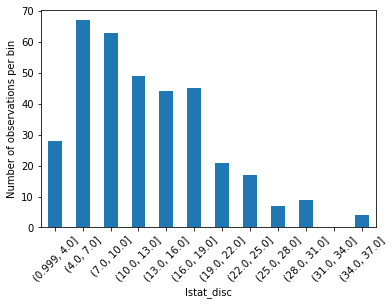

In [11]:
# let's plot the number of observations per bin

X_train.groupby('lstat_disc')['LSTAT'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Maintenant, discrétisons LSTAT dans l'ensemble de test en utilisant la méthode cut() des pandas

In [12]:
# let's discretise the variables in the test set

X_test['lstat_disc'] = pd.cut(x=X_test['LSTAT'],
                              bins=intervals,
                              include_lowest=True)

X_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,lstat_disc
329,0.06724,0.0,3.24,0.0,0.460,6.333,17.2,5.2146,4.0,430.0,16.9,375.21,7.34,"(7.0, 10.0]"
371,9.23230,0.0,18.10,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,"(7.0, 10.0]"
219,0.11425,0.0,13.89,1.0,0.550,6.373,92.4,3.3633,5.0,276.0,16.4,393.74,10.50,"(10.0, 13.0]"
403,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77,"(19.0, 22.0]"
78,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,386.40,12.34,"(10.0, 13.0]"


Si la distribution des variables dans les ensembles de train et de test est similaire, nous devrions nous attendre à une proportion similaire d'observations sur les intervalles LSTAT dans le train et les ensembles de test

Traçons la proportion d'observations sur les intervalles LSTAT dans les ensembles d'apprentissage et de test

Text(0, 0.5, 'Number of observations per bin')

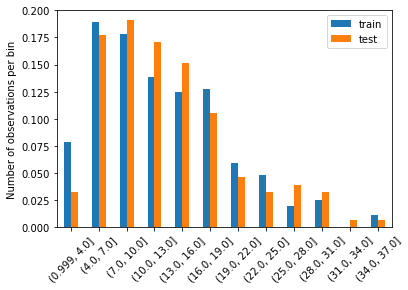

In [13]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

# determine proportion of observations in each bin
t1 = X_train['lstat_disc'].value_counts() / len(X_train)
t2 = X_test['lstat_disc'].value_counts() / len(X_test)

# concatenate aggregated views
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']

# plot
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Nous pouvons voir dans la sortie que la proportion d'observations par intervalle est à peu près la même dans les ensembles de train et de test

### Discrétisation à largeur égale avec Scikit-Learn


Faisons maintenant une discrétisation à largeur égale avec scikit-learn. Tout d'abord, divisons les données d'origine en ensembles d'apprentissage et de test

In [14]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

Créons un discrétiseur de largeur égale avec scikit-learn en définissant sa stratégie sur uniform

In [15]:
# let's set up an equal-width discretizer into 10 intervals

disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# let's fit the discretizer so it learns the interval limits
disc.fit(X_train[['LSTAT', 'DIS', 'RM']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [16]:
# the interval limits are stored in the bin_edges_attribute

disc.bin_edges_

array([array([ 1.73 ,  5.255,  8.78 , 12.305, 15.83 , 19.355, 22.88 , 26.405,
       29.93 , 33.455, 36.98 ]),
       array([ 1.1742 ,  2.26943,  3.36466,  4.45989,  5.55512,  6.65035,
        7.74558,  8.84081,  9.93604, 11.03127, 12.1265 ]),
       array([3.561 , 4.0829, 4.6048, 5.1267, 5.6486, 6.1705, 6.6924, 7.2143,
       7.7362, 8.2581, 8.78  ])], dtype=object)

N'oubliez pas que scikit-learn renvoie des tableaux NumPy. Pour convertir le tableau en un pandasdataframe, nous pouvons exécuter train_t = pd.DataFrame(train_t, colonnes =['LSTAT', 'DIS', 'RM'])

In [17]:

# let's transform the train set, remember that Sklearn returns Numpy arrays
train_t = disc.transform(X_train[['LSTAT', 'DIS', 'RM']])

# transform array to dataframe
train_t = pd.DataFrame(train_t, columns = ['LSTAT', 'DIS', 'RM'])

train_t.head()

,LSTAT,DIS,RM
0,9.0,0.0,2.0
1,1.0,2.0,5.0
2,4.0,0.0,5.0
3,0.0,6.0,5.0
4,4.0,0.0,4.0


In [18]:

# same thing for test set

test_t = disc.transform(X_test[['LSTAT', 'DIS', 'RM']])

test_t = pd.DataFrame(test_t, columns = ['LSTAT', 'DIS', 'RM'])

Text(0, 0.5, 'Number of observations per bin')

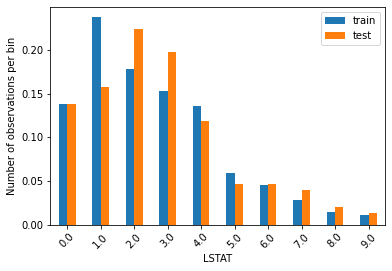

In [19]:

# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set

# LSTAT

t1 = train_t.groupby(['LSTAT'])['LSTAT'].count() / len(train_t)
t2 = test_t.groupby(['LSTAT'])['LSTAT'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

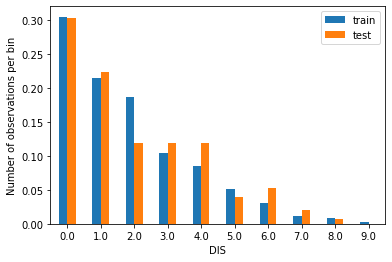

In [20]:
# DIS

t1 = train_t.groupby(['DIS'])['DIS'].count() / len(train_t)
t2 = test_t.groupby(['DIS'])['DIS'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

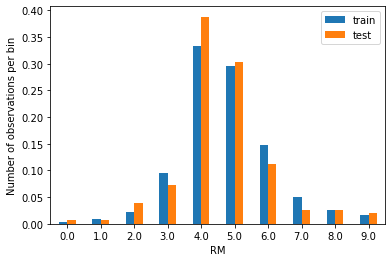

In [21]:
# RM

t1 = train_t.groupby(['RM'])['RM'].count() / len(train_t)
t2 = test_t.groupby(['RM'])['RM'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Dans cette recette, nous avons effectué une discrétisation de largeur égale, c'est-à-dire que nous avons trié les valeurs des variables en intervalles équidistants. Nous avons arbitrairement défini le nombre de cases à 10, puis calculé la différence entre la valeur maximale et minimale de la variable LSTAT, en utilisant les méthodes pandas max() et min(). Avec les méthodes floor() et ceil() de NumPy, nous avons obtenu respectivement les valeurs minimales et maximales arrondies vers le bas ou vers le haut. Nous avons ensuite estimé la longueur de l'intervalle en divisant la plage de valeurs, c'est-à-dire la valeur maximale moins les valeurs minimales, par le nombre de cases. Enfin, nous avons capturé les limites d'intervalle dans une liste, en utilisant les valeurs minimales et maximales, et la largeur d'intervalle dans une liste.

Pour discrétiser la variable LSTAT, nous avons utilisé la méthode pandas cut() et les limites d'intervalle que nous avons créées avec la compréhension de liste, pour allouer les valeurs des variables dans chaque intervalle. Nous avons ensuite utilisé la méthode value_counts() des pandas pour compter le nombre d'observations par intervalle.

Pour comparer la distribution des observations dans les intervalles de largeur égale dans le train et l'ensemble de test, nous avons produit un graphique à barres avec le pourcentage d'observations par intervalle dans chaque ensemble de données. Pour créer ce graphique, nous avons utilisé la méthode value_counts() des pandas pour compter le nombre d'observations par intervalle et divisé ces nombres par le nombre total d'observations dans le train ou les ensembles de test, que nous avons calculés à l'aide de la méthode len(), pour déterminer le pourcentage d'observations par intervalle. Pour tracer ces proportions, nous avons d'abord concaténé la série train et test à l'aide de la fonction concat() des pandas dans une base de données temporaire, puis nous lui avons attribué les noms de colonne de train et test. Enfin, nous avons utilisé pandas'plot.bar() pour afficher un graphique à barres. Nous avons fait pivoter les étiquettes avec la méthode xticks() de Matplotlib et ajouté la légende y avec ylabel().

Enfin, nous avons discrétisé trois variables continues dans des bacs de largeur égale avec KBinsDiscretizer() de scikit-learn, en indiquant le nombre de bacs comme argument et en définissant la stratégie sur uniforme. Avec la méthode fit () et le train défini comme argument, le transformateur a appris les limites des intervalles pour chaque variable dans la dataframe, et avec la méthode transform (), le transformateur a trié les valeurs dans chaque intervalle, renvoyant un tableau NumPy avec les variables discrétisées. Les valeurs des variables discrétisées sont également des chiffres représentant les intervalles.
